In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models


In [40]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor(), # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
eurosat = torchvision.datasets.EuroSAT(root="/Home/Documents", download=True, transform=transform)

In [42]:
device

device(type='cuda')

In [43]:
classes = eurosat.classes
eurosat.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

<class 'torchvision.datasets.eurosat.EuroSAT'>
<class 'torch.utils.data.dataset.Subset'>
27000
21600


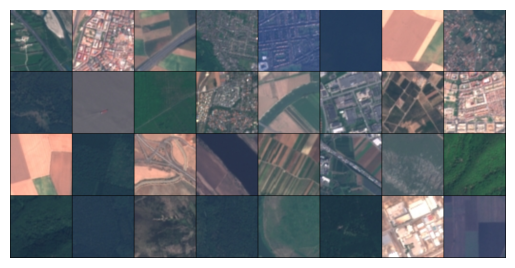

In [44]:
print(type(eurosat))
subset_start = 0
subset_end = 27000
subset_indices = list(range(subset_start, subset_end))
subset = torch.utils.data.Subset(eurosat, subset_indices)
print(type(subset))
total_samples = len(eurosat)
total_samples = len(subset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size
print(total_samples)
print(train_size)
train_dataset, test_dataset = torch.utils.data.random_split(subset, [train_size, test_size])
train = DataLoader(train_dataset, batch_size=32, shuffle=True)
test = DataLoader(test_dataset, batch_size=32)
images, labels = next(iter(train))
# Visualize the images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
imshow(torchvision.utils.make_grid(images))


In [8]:
model = models.resnet50(weights='DEFAULT', progress=True)
model = model.to(device)
# 'IMAGENET1K_V1'

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.6MB/s]


In [47]:
!pip install torchsummary

In [48]:
import torchsummary
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(eurosat.classes))
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  running_total_correct = 0.0
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()        
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [23]:
n_epochs = 5
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [26]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels) 
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [28]:
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train, criterion, optimizer)
  test_loss, _ = evaluate(model, test, criterion)
  
  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


NameError: name 'tqdm' is not defined

In [9]:
num_classes = len(eurosat.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, labels in train:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
model.eval()
correct = 0
total = 0
n = 0
with torch.no_grad():
    for images, labels in test:
        n = n+1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if n%10 == 0:
            print(n, end=" ")
            print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the test set: {:.2f}%'.format(100 * accuracy))


Epoch 1/1, Loss: 0.0698
10 tensor([8, 9, 8, 1, 5, 4, 4, 2, 8, 1, 2, 3, 8, 4, 4, 7, 4, 2, 8, 2, 6, 8, 5, 7,
        0, 3, 0, 0, 8, 4, 9, 2], device='cuda:0')
20 tensor([1, 1, 6, 8, 0, 3, 3, 4, 5, 5, 3, 0, 7, 3, 9, 8, 5, 6, 7, 1, 1, 2, 0, 0,
        1, 0, 3, 3, 4, 0, 4, 0], device='cuda:0')
30 tensor([0, 6, 7, 5, 9, 2, 7, 9, 5, 8, 2, 5, 1, 0, 0, 4, 9, 7, 6, 3, 0, 1, 7, 8,
        8, 4, 7, 5, 3, 4, 2, 0], device='cuda:0')
40 tensor([9, 4, 4, 3, 6, 9, 9, 2, 7, 7, 7, 4, 7, 4, 2, 6, 0, 0, 2, 3, 1, 8, 2, 1,
        9, 2, 1, 7, 8, 8, 4, 1], device='cuda:0')
50 tensor([6, 4, 5, 8, 3, 0, 3, 6, 2, 6, 5, 5, 0, 1, 7, 3, 8, 7, 2, 9, 0, 0, 2, 3,
        1, 2, 3, 6, 7, 3, 1, 6], device='cuda:0')
60 tensor([7, 6, 2, 5, 0, 9, 1, 2, 4, 9, 1, 1, 9, 2, 7, 7, 0, 9, 4, 2, 1, 2, 6, 9,
        2, 9, 7, 2, 9, 0, 1, 3], device='cuda:0')
70 tensor([0, 4, 1, 1, 9, 0, 7, 2, 4, 5, 9, 7, 0, 6, 2, 0, 1, 1, 1, 7, 5, 7, 7, 5,
        6, 6, 8, 1, 5, 9, 8, 3], device='cuda:0')
80 tensor([1, 3, 1, 5, 0, 2, 8, 1, 2, 2, 9, 1

In [20]:
import torch
import torch.nn as nn

class Conv2DBatchNormReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1):
        super(Conv2DBatchNormReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x


In [10]:
from PIL import Image 
import json 
import io 
img_path = "/kaggle/input/mumbaisatpng/MumbaiSAT.png" 

# image = Image.open(img_path)
# image = Image.open(image)
image = Image.open(img_path)
# image.show()
# image

print(type(image)) 
print(image.size)
image.show()

<class 'PIL.PngImagePlugin.PngImageFile'>
(792, 1167)


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmpzxucdmx0.PNG'


In [11]:
def make_grid(img, r, c):
  width, height = img.size
  tile_width = width // c
  tile_height = height // r
  tiles = []
  for row in range(r):
    for col in range(c):
      left = col * tile_width
      upper = row * tile_height
      right = left + tile_width
      lower = upper + tile_height
      tile = image.crop((left, upper, right, lower))
      tiles.append(tile)
  return tiles

r = 20
c = 10
image_grid = make_grid(image, r, c)
# for i, tile in enumerate(image_grid):
#     print(f"Tile {i+1}:")
#     image_grid[i]
print(type(image_grid[5]))
print((image_grid[5]).size)
image_grid[79]
print(len(image_grid))

<class 'PIL.Image.Image'>
(79, 58)
200


In [12]:
import torch
from torch.utils.data import Dataset, Subset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.image_list[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Assuming 'image_list' is a list of PIL.Image objects
# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Create a custom dataset instance
custom_dataset = CustomDataset(image_list=image_grid, transform=transform)
# Create a subset of the custom dataset
subset_indices = [0, 1, 2, 3]  # Example subset indices (you can use any subset indices)
subset_dataset = Subset(custom_dataset, subset_indices)

# Example usage
# You can now use 'subset_dataset' like any other PyTorch dataset
print(type(custom_dataset))

<class '__main__.CustomDataset'>


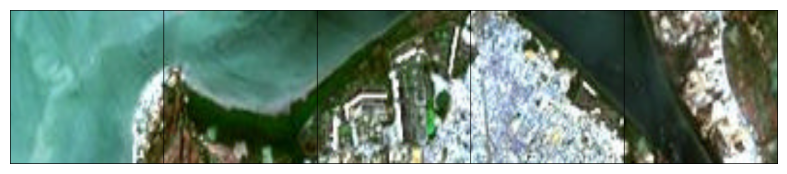

In [13]:
testsub = DataLoader(custom_dataset, batch_size=5)
# images = next(iter(train))
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(dataloader, num_images=6):
    # Get a batch of images from the data loader
    dataiter = iter(dataloader)
    images = next(dataiter)

    # Plot the images
    plt.figure(figsize=(10, 2))
    plt.axis("off")
    # plt.title("Sample Images")
    plt.imshow(vutils.make_grid(images[:num_images], nrow=num_images, padding=1, normalize=True).permute(1, 2, 0).numpy())
    plt.show()

# Assuming dataloader is your DataLoader object
show_images(testsub)

In [14]:
testsub

In [15]:
test

In [16]:
from torch.utils.data import ConcatDataset
data1 = test.dataset
data2 = testsub.dataset
dataset = ConcatDataset([data1, data2])
print(type(dataset))

<class 'torch.utils.data.dataset.ConcatDataset'>


In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize the image to 224x224 pixels
#     transforms.ToTensor(),                            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image
                         std=[0.229, 0.224, 0.225])
])

In [19]:
num_classes = len(eurosat.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, labels in train:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
model.eval()
correct = 0
total = 0
n = 0
with torch.no_grad():
    for images, labels in dataset:
        n = n+1
        images = images.to(device)
#         labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if n%10 == 0:
            print(n, end=" ")
            print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the test set: {:.2f}%'.format(100 * accuracy))


Epoch 1/1, Loss: 0.2261


ValueError: expected 4D input (got 3D input)

In [51]:
predictions=[]
labels=[]
targets = eurosat.classes
for images in testsub:
    # Preprocess images
    print(type(images))
    images = torch.stack([transform(img) for img in images])
    images = images.to(device)
    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        print(outputs)
        print(type(outputs))
    # Collect predictions
#     _, predicted = torch.max(outputs, 1)
#     predictions.extend(predicted.tolist())
#     labels.extend(targets.tolist())

    

<class 'torch.Tensor'>
tensor([[  145.8207,   -10.2429,   -62.7129,    36.5953,   -77.3331,   -68.8205,
            13.5573,  -151.9755,    68.6540,   179.1476],
        [  688.4761,  -304.3313,  -826.8898,    -7.7888,   -46.9837,  -332.1473,
         -1084.4208, -1776.6469,  1428.6799,  2782.2839],
        [  313.1963,   232.9869,  -860.2106,  -223.6322,    96.0338,  -450.6529,
         -1136.5660, -1855.2701,  1390.3723,  3359.3069],
        [  278.3598,   261.0076,  -674.7707,  -176.6832,  -159.7297,  -248.5797,
          -845.0074, -1416.6891,   769.1982,  2343.0442]], device='cuda:0')
<class 'torch.Tensor'>
